In [1]:
import pandas as pd

# Load Dataset
data = pd.read_csv("amazon_reviews.csv")  # Replace with your dataset path

# Create Sentiment Column
def label_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

data['sentiment'] = data['rating'].apply(label_sentiment)
print(data[['rating', 'sentiment']].head())


   rating sentiment
0       1  negative
1       5  positive
2       1  negative
3       1  negative
4       5  positive


In [2]:
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK data (if running for the first time)
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    if not isinstance(text, str):
        return ""  # Return an empty string for non-string values
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove non-alphabet characters
    text = text.lower()  # Convert to lowercase
    text = text.split()
    text = [lemmatizer.lemmatize(word) for word in text if word not in stop_words]
    return " ".join(text)

data['cleaned_review'] = data['review'].apply(clean_text)
print(data[['review', 'cleaned_review']].head())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kisla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kisla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                              review  \
0  I bought this hair oil after viewing so many g...   
1  Used This Mama Earth Newly Launched Onion Oil ...   
2  So bad product...My hair falling increase too ...   
3  Product just smells similar to navarathna hair...   
4  I have been trying different onion oil for my ...   

                                      cleaned_review  
0  bought hair oil viewing many good comment prod...  
1  used mama earth newly launched onion oil twice...  
2  bad productmy hair falling increase muchi orde...  
3  product smell similar navarathna hair oil stro...  
4  trying different onion oil hair hair healthy p...  


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# Vectorize Text
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(data['cleaned_review'])
y = data['sentiment']

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Model
model = LogisticRegression()
model.fit(X_train, y_train)

# Evaluate
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

    negative       0.94      0.77      0.85       132
     neutral       1.00      0.16      0.28        37
    positive       0.87      0.99      0.93       388

    accuracy                           0.89       557
   macro avg       0.94      0.64      0.68       557
weighted avg       0.89      0.89      0.87       557



In [4]:
# Convert Date Column to Datetime
data['date'] = pd.to_datetime(data['date'])

# Assign Numerical Scores to Sentiments
sentiment_mapping = {'positive': 1, 'neutral': 0, 'negative': -1}
data['sentiment_score'] = data['sentiment'].map(sentiment_mapping)

# Aggregate Monthly Sentiment Scores
monthly_trends = data.groupby(data['date'].dt.to_period('M'))['sentiment_score'].mean().reset_index()
monthly_trends['date'] = monthly_trends['date'].dt.to_timestamp()
print(monthly_trends.head())


        date  sentiment_score
0 2015-04-01              0.0
1 2015-05-01             -1.0
2 2015-12-01              1.0
3 2016-01-01              1.0
4 2016-02-01              1.0


59    0.428154
60    0.513470
61    0.400827
62    0.392573
63    0.435494
64    0.472980
65    0.452417
66    0.469145
67    0.427136
68    0.431302
69    0.438706
70    0.450801
Name: predicted_mean, dtype: float64


C:\Users\kisla\AppData\Local\Temp\ipykernel_10884\26255896.py:15: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  plt.plot(pd.date_range(start=monthly_trends['date'].iloc[-1], periods=12, freq='M'), forecast, label='Forecast', color='red')


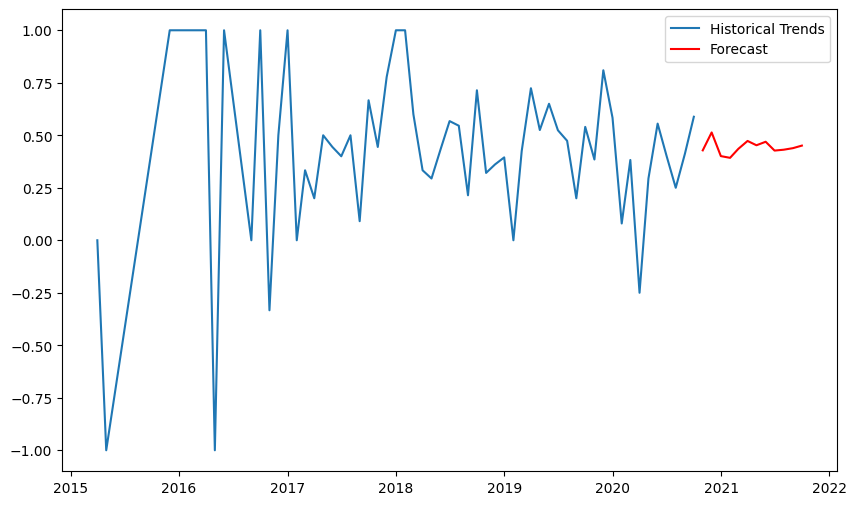

In [5]:
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# Fit ARIMA Model
model = ARIMA(monthly_trends['sentiment_score'], order=(5, 1, 0))  # Adjust order as needed
model_fit = model.fit()

# Forecast
forecast = model_fit.forecast(steps=12)  # Forecast for next 12 months
print(forecast)

# Plot Trends
plt.figure(figsize=(10, 6))
plt.plot(monthly_trends['date'], monthly_trends['sentiment_score'], label='Historical Trends')
plt.plot(pd.date_range(start=monthly_trends['date'].iloc[-1], periods=12, freq='M'), forecast, label='Forecast', color='red')
plt.legend()
plt.show()


In [7]:
# Train Logistic Regression for sentiment analysis
sentiment_model = LogisticRegression()
sentiment_model.fit(X_train, y_train)

# Sample review data to predict sentiment for
sample_reviews = [
    "The camera quality is amazing and the battery life is impressive!",
    "The product was okay, but the delivery was late.",
    "I am very disappointed with the purchase. It broke within a week."
]

# Preprocess the sample reviews (clean and vectorize)
sample_reviews_cleaned = [clean_text(review) for review in sample_reviews]
sample_reviews_vectorized = tfidf.transform(sample_reviews_cleaned)

# Make predictions using the trained Logistic Regression model
predictions = sentiment_model.predict(sample_reviews_vectorized)

# Print the predictions
for review, sentiment in zip(sample_reviews, predictions):
    print(f"Review: {review}\nPredicted Sentiment: {sentiment}\n")


Review: The camera quality is amazing and the battery life is impressive!
Predicted Sentiment: positive

Review: The product was okay, but the delivery was late.
Predicted Sentiment: positive

Review: I am very disappointed with the purchase. It broke within a week.
Predicted Sentiment: negative

